In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from collections import Counter

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tnrange

import gensim

Using TensorFlow backend.


In [2]:
# !! unzip data.zip

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [4]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))

    return codones

In [5]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [6]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [7]:
######################

In [8]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    
    size = len(index_words_list)
    ran = list(range(size))
    random.shuffle(ran)
    
#     for index_words in index_words_list:
#         for index, center in enumerate(index_words):

    for i in ran:
        for index, center in enumerate(index_words_list[i]):
            context = random.randint(1, context_window_size)
            
            # get a random target before the center word
#             for target in index_words[max(0, index - context): index]:
            for target in index_words_list[i][max(0, index - context): index]:
                yield center, target
            
            # get a random target after the center wrod
#             for target in index_words[index + 1: index + context + 1]:
            for target in index_words_list[i][index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]


def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
#     unique_codones = set(flat_codones)
    
    counter = Counter(flat_codones)
    
    unique_codones = list(set(flat_codones))
    unique_codones = sorted(unique_codones, key=lambda x: counter[x], 
                            reverse=True)
    
#     print(unique_codones[:6])
    
#     count = 0

#     for key in unique_codones:
#         print(key, counter[key])
#         count += 1
#         if count > 6:
#             break
            
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

from tqdm import tqdm_notebook
def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [9]:
# all_codones = np.array([[['abc', 'gec', 'agc'], ['get', 'ghe', 'acg']]])

# dictionary = make_dictionary(all_codones)

# print(len(dictionary.keys()))

In [10]:
# BATCH_SIZE = 128
# SKIP_WINDOW = 10  # the context window

# batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [11]:

def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

dictionary = make_dictionary(all_codones)

BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [12]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

props.head()

acid      mass  volume  hydrophobicity  number_of_atoms  kdHydrophobicitya  \
0    A   71.0779    88.6             1.8             13.0                1.8   
1    R  156.1857   173.4            -4.5             26.0               -4.5   
2    N  114.1026   114.1            -3.5             17.0               -3.5   
3    D  115.0874   111.1            -3.5             16.0               -3.5   
4    B  114.5950   112.6            -3.5             16.5               -3.5   

   wwHydrophobicityb  hhHydrophobicityc  mfHydrophobicityd  Interface_Scale  \
0             -0.170               0.11               0.00             0.17   
1             -0.810               2.58               3.71             0.81   
2             -0.420               2.05               3.47             0.42   
3             -1.230               3.49               2.95             0.58   
4             -0.825               2.77               3.21             0.50   

   Octanol_Scale  Octanol_Interface_Scale  
0         0.5000                   0.3300  
1         1.8100                   1.0000  
2         0.8500                   0.4300  
3         2.0350                   1.4550  
4         1.4425                   0.9425

In [13]:
props['hydrophobicity'] = props['Interface_Scale']

In [14]:
all_codones_set = set(flatten(all_codones))

In [15]:
def acid_dict(some_c, props):    
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    
    # dont forget about h20 yield
    res = dict()
    res['mass'] = df_concat['mass'].mean()
    res['number_of_atoms'] = df_concat['number_of_atoms'].mean()
    res['hydrophobicity'] = df_concat['hydrophobicity'].mean()
    res['volume'] = df_concat['volume'].mean()
    
    dres = dict(res)
    dres['acid'] = some_c
    return dres

save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in all_codones_set]
all_acid_dicts = read_or_create(save_path, producer)

all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

reading data/all_acid_dicts.pickle


acid  hydrophobicity        mass  number_of_atoms      volume
0  MEV        0.283333  119.813733        19.333333  147.100000
1  NFV       -0.213333  120.135867        19.666667  148.000000
2  FRY       -0.420000  155.510967        24.333333  185.633333
3  VMV       -0.030000  109.819433        19.333333  147.633333
4  HDQ        0.575000  126.785300        18.666667  136.033333

In [16]:
######################

In [17]:
def create_fully_conn(input_tensor, from_n, to_n, layer_name, activ_func=tf.nn.tanh):
#     from_n = int(from_n)
#     to_n = int(to_n)

    with tf.name_scope(layer_name):
        W_fc = tf.Variable(tf.truncated_normal(shape=from_n, stddev=0.1), name=layer_name + '_W')
        b_fc = tf.Variable(tf.constant(0.1, shape=to_n), name=layer_name + '_b')
        h_fc = activ_func(tf.add(tf.matmul(input_tensor, W_fc), b_fc))
        return h_fc


def create_fully_conn_logit(input_tensor, from_shape, to_shape, layer_name):
#     from_n = int(from_n)
#     to_n = int(to_n)

    with tf.name_scope(layer_name):
        W_fc = tf.Variable(tf.truncated_normal(shape=from_shape, stddev=0.1), name=layer_name + '_W')
        b_fc = tf.Variable(tf.constant(0.1, shape=to_shape), name=layer_name + '_b')
        h_fc = tf.add(tf.matmul(input_tensor, W_fc), b_fc)
        return h_fc    

class SkipGramModel:
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver()  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')
    
    def _create_embedding(self):
        with tf.name_scope("embed"):
            base_var = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size], stddev=0.1),
                                            name='base_var')     
            
            var_exp = tf.reshape(base_var, (1, self.vocab_size, self.embed_size), name='var_exp')
            
            filter_W = tf.Variable(tf.constant(0.1, shape=[5, self.embed_size, self.embed_size]), name='filter_W')
            conv_lay = tf.nn.conv1d(var_exp, filter_W, stride=1, padding='SAME', name='em')
            conv_reshape = tf.reshape(conv_lay, shape=(self.vocab_size, self.embed_size))
            
            self.embed_matrix = create_fully_conn(conv_reshape, (self.embed_size, self.embed_size),
                                                        (self.embed_size,), 'fc1')
            
            
#             fc1 = create_fully_conn_logit(base_var, self.embed_size, self.embed_size*0.75, 'fc1')
#             self.embed_matrix = create_fully_conn(fc1, self.embed_size*0.75, self.embed_size, 'em', tf.nn.tanh)
            
#             fc1 = create_fully_conn_logit(base_var, self.embed_size, self.embed_size*fc1_ratio, 'fc1')
#             self.embed_matrix =  create_fully_conn(base_var, self.embed_size, self.embed_size, 
#                                                   'em', tf.nn.elu)
            
    def _create_loss(self):
        with tf.name_scope("loss"):
            embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

            # construct variables for NCE loss
            nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)),
                                     name='nce_weight')
            
            nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')

            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                      biases=nce_bias,
                                                      labels=self.target_words,
                                                      inputs=embed,
                                                      num_sampled=self.num_sampled,
                                                      num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
#         self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
#         self.optimizer = tf.train.AdagradOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
#         self.optimizer = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
        
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram_loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [18]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 16  # Number of negative examples to sample.
LEARNING_RATE = .001
NUM_TRAIN_STEPS = 1000000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

In [19]:
######################

In [20]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [21]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    
    with tf.Session(graph=g, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        
        for index in tnrange(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
#             print(centers[:5], targets[:5])
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op],
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.embed_matrix)
        return final_embed_matrix

In [38]:
final_embed_matrix = train_model(model, batch_gen, 1000000, LEARNING_RATE, SKIP_STEP)

Average loss at step 1999:  67.4
Average loss at step 3999:  61.1
Average loss at step 5999:  54.4
Average loss at step 7999:  49.8
Average loss at step 9999:  46.6
Average loss at step 11999:  44.0
Average loss at step 13999:  40.7
Average loss at step 15999:  38.6
Average loss at step 17999:  36.7
Average loss at step 19999:  35.4
Average loss at step 21999:  32.8
Average loss at step 23999:  31.5
Average loss at step 25999:  30.4
Average loss at step 27999:  29.1
Average loss at step 29999:  28.1
Average loss at step 31999:  27.3
Average loss at step 33999:  26.3
Average loss at step 35999:  25.6
Average loss at step 37999:  24.9
Average loss at step 39999:  23.9
Average loss at step 41999:  23.1
Average loss at step 43999:  22.5
Average loss at step 45999:  22.5
Average loss at step 47999:  21.7
Average loss at step 49999:  21.0
Average loss at step 51999:  20.8
Average loss at step 53999:  20.0
Average loss at step 55999:  19.6
Average loss at step 57999:  19.6
Average loss at ste

Average loss at step 473999:   3.2
Average loss at step 475999:   3.3
Average loss at step 477999:   3.2
Average loss at step 479999:   3.3
Average loss at step 481999:   3.2
Average loss at step 483999:   3.2
Average loss at step 485999:   3.1
Average loss at step 487999:   3.0
Average loss at step 489999:   3.2
Average loss at step 491999:   3.2
Average loss at step 493999:   3.2
Average loss at step 495999:   3.2
Average loss at step 497999:   3.7
Average loss at step 499999:   3.6
Average loss at step 501999:   3.5
Average loss at step 503999:   3.5
Average loss at step 505999:   3.5
Average loss at step 507999:   3.5
Average loss at step 509999:   3.5
Average loss at step 511999:   3.6
Average loss at step 513999:   3.5
Average loss at step 515999:   3.4
Average loss at step 517999:   3.5
Average loss at step 519999:   3.4
Average loss at step 521999:   3.4
Average loss at step 523999:   3.5
Average loss at step 525999:   3.5
Average loss at step 527999:   3.4
Average loss at step

Average loss at step 943999:   3.3
Average loss at step 945999:   3.3
Average loss at step 947999:   3.3
Average loss at step 949999:   3.2
Average loss at step 951999:   3.1
Average loss at step 953999:   3.1
Average loss at step 955999:   3.0
Average loss at step 957999:   3.1
Average loss at step 959999:   3.2
Average loss at step 961999:   3.3
Average loss at step 963999:   3.2
Average loss at step 965999:   3.1
Average loss at step 967999:   3.1
Average loss at step 969999:   3.1
Average loss at step 971999:   2.9
Average loss at step 973999:   3.0
Average loss at step 975999:   3.3
Average loss at step 977999:   3.3
Average loss at step 979999:   3.3
Average loss at step 981999:   3.3
Average loss at step 983999:   3.2
Average loss at step 985999:   3.3
Average loss at step 987999:   3.3
Average loss at step 989999:   3.2
Average loss at step 991999:   3.2
Average loss at step 993999:   3.3
Average loss at step 995999:   3.2
Average loss at step 997999:   3.3
Average loss at step

In [39]:
######################

In [37]:
def plot_df(tsne_df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(tsne_df.x0, tsne_df.x1, s=10)
    plt.show()

In [38]:
def plot_tsne_df(matrix):
    tsne = TSNE(n_components=2, random_state=42)
    XX = tsne.fit_transform(matrix)
    
    tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
    unique_codones = sorted(dictionary, key=dictionary.get)
    tsne_df['codone'] = list(unique_codones)
#     tsne_df.head()
    
    plot_df(tsne_df)
    
    return tsne_df

In [39]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], cmap='plasma', s=10)
    plt.show()

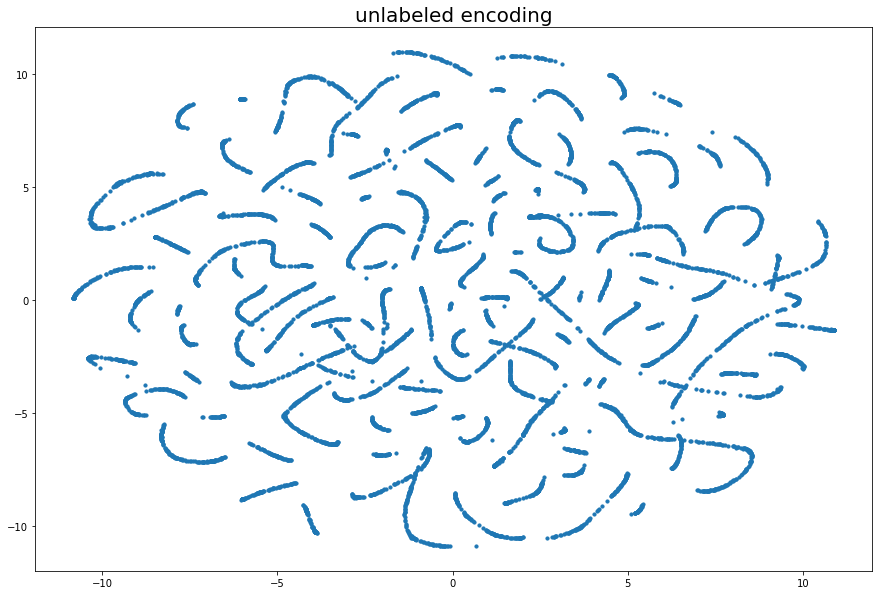

In [43]:
tsne_df = plot_tsne_df(final_embed_matrix)

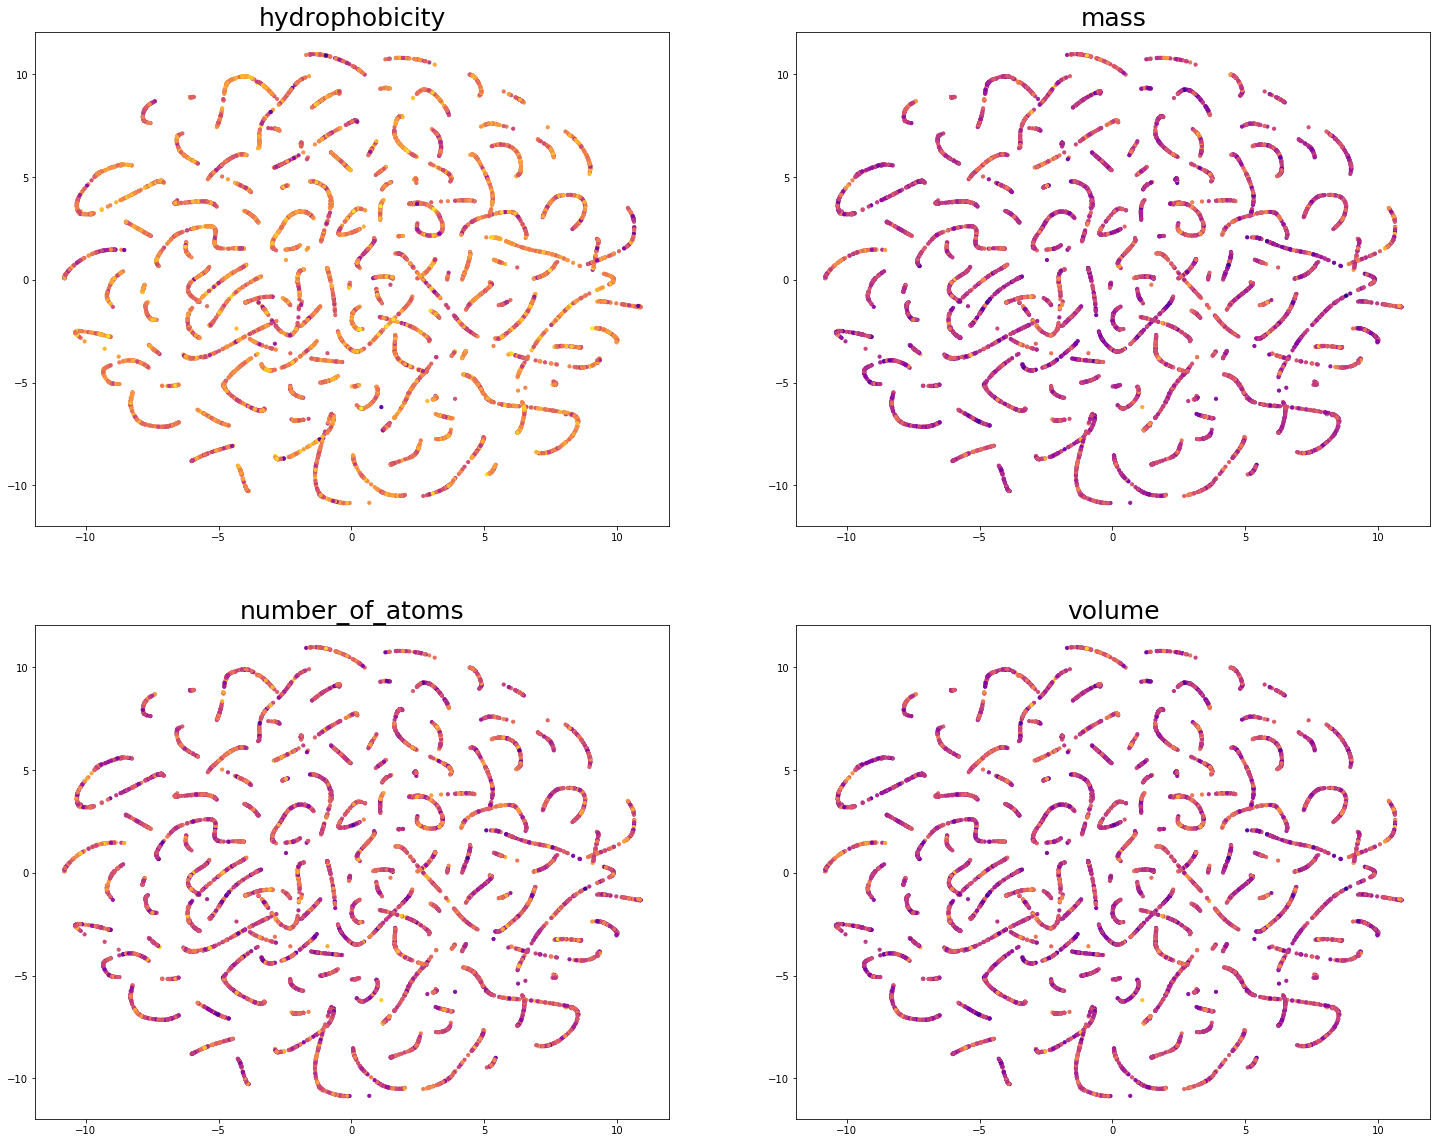

In [44]:
tsne_df = plot_tsne_df(final_embed_matrix)
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
plot_embedding_properties(final_df)

In [53]:
from sklearn.manifold import MDS, SpectralEmbedding, Isomap

def plot_manifold_df(matrix, method=TSNE):
    if method is Isomap:
        tsne = method(n_components=2)
    else:
        tsne = method(n_components=2, random_state=42)
    XX = tsne.fit_transform(matrix)
    
    tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
    unique_codones = sorted(dictionary, key=dictionary.get)
    tsne_df['codone'] = list(unique_codones)
#     tsne_df.head()
    
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(tsne_df.x0, tsne_df.x1, s=10)
    plt.show()
    
    return tsne_df

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_manifold_df_3d(matrix, method=TSNE):
    tsne = method(n_components=3, random_state=42)
    XX = tsne.fit_transform(matrix)
    
    tsne_df = pd.DataFrame(XX, columns=['x0', 'x1', 'x2'])
    unique_codones = sorted(dictionary, key=dictionary.get)
    tsne_df['codone'] = list(unique_codones)
#     tsne_df.head()
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('unlabeled encoding', fontsize=20)
    ax.scatter(tsne_df.x0, tsne_df.x1, tsne_df.x2, s=10)
#     plt.show()
    
    return tsne_df

def plot_embedding_properties_3d(final_df):
#     plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        fig = plt.figure(figsize=(15,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(final_df.x0, final_df.x1, final_df.x2, c=final_df[p], cmap='plasma', s=10)
        ax.set_title(p)
    plt.show()

In [54]:
se_3d_df = plot_manifold_df_3d(final_embed_matrix, SpectralEmbedding)

In [49]:
# final_df_3d = all_acid_df_ok.join(se_3d_df.set_index('codone'), on='acid')
# plot_embedding_properties_3d(final_df_3d)

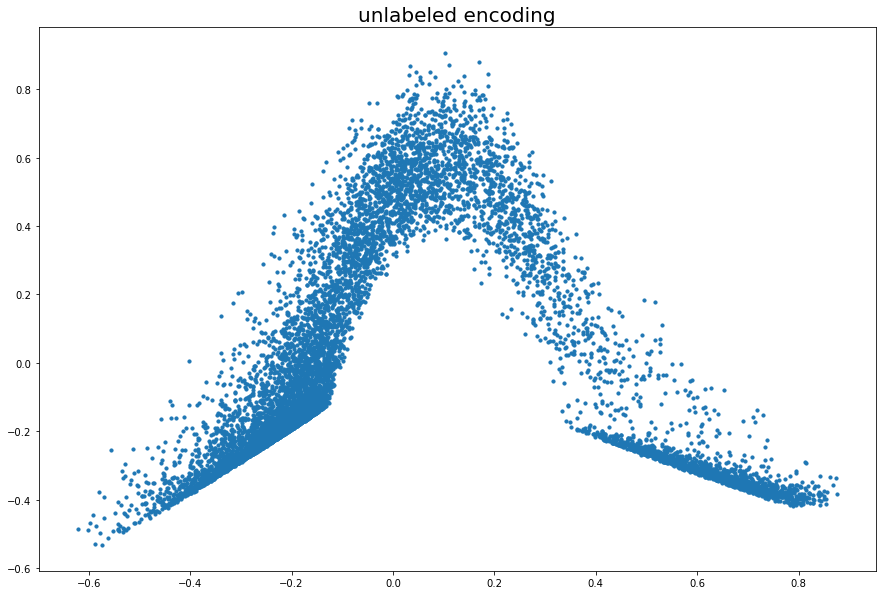

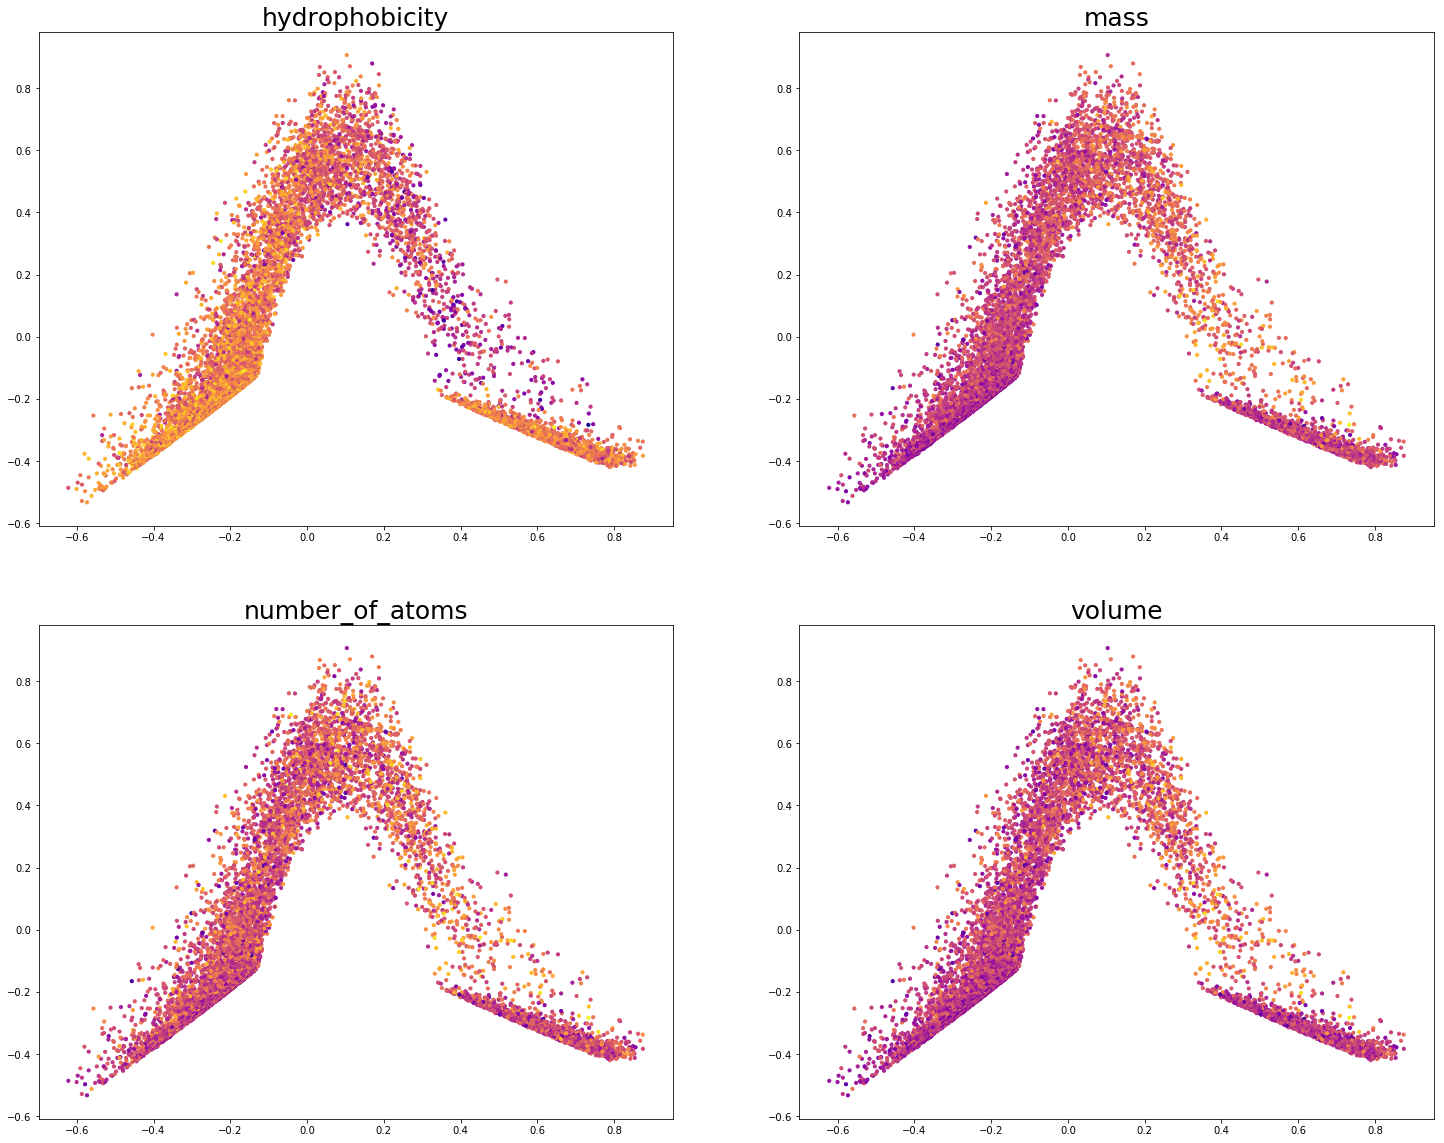

In [56]:
pca_df = plot_manifold_df(final_embed_matrix, SpectralEmbedding)
final_df = all_acid_df_ok.join(pca_df.set_index('codone'), on='acid')
plot_embedding_properties(final_df)

In [103]:
# pca_df = plot_manifold_df(final_embed_matrix, MDS)
# final_df = all_acid_df_ok.join(pca_df.set_index('codone'), on='acid')
# plot_embedding_properties(final_df)

In [33]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

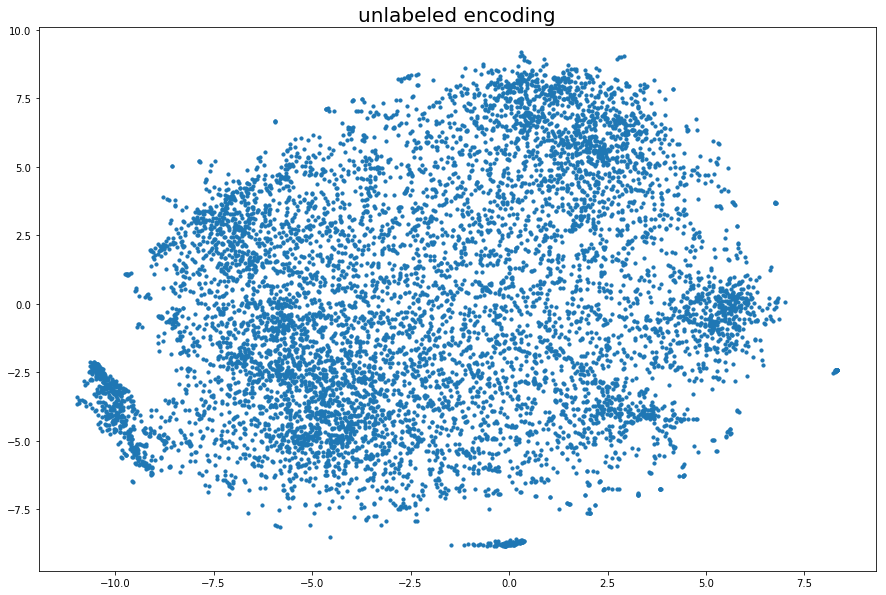

In [37]:
plot_df(gensim_tsne_df)

In [38]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

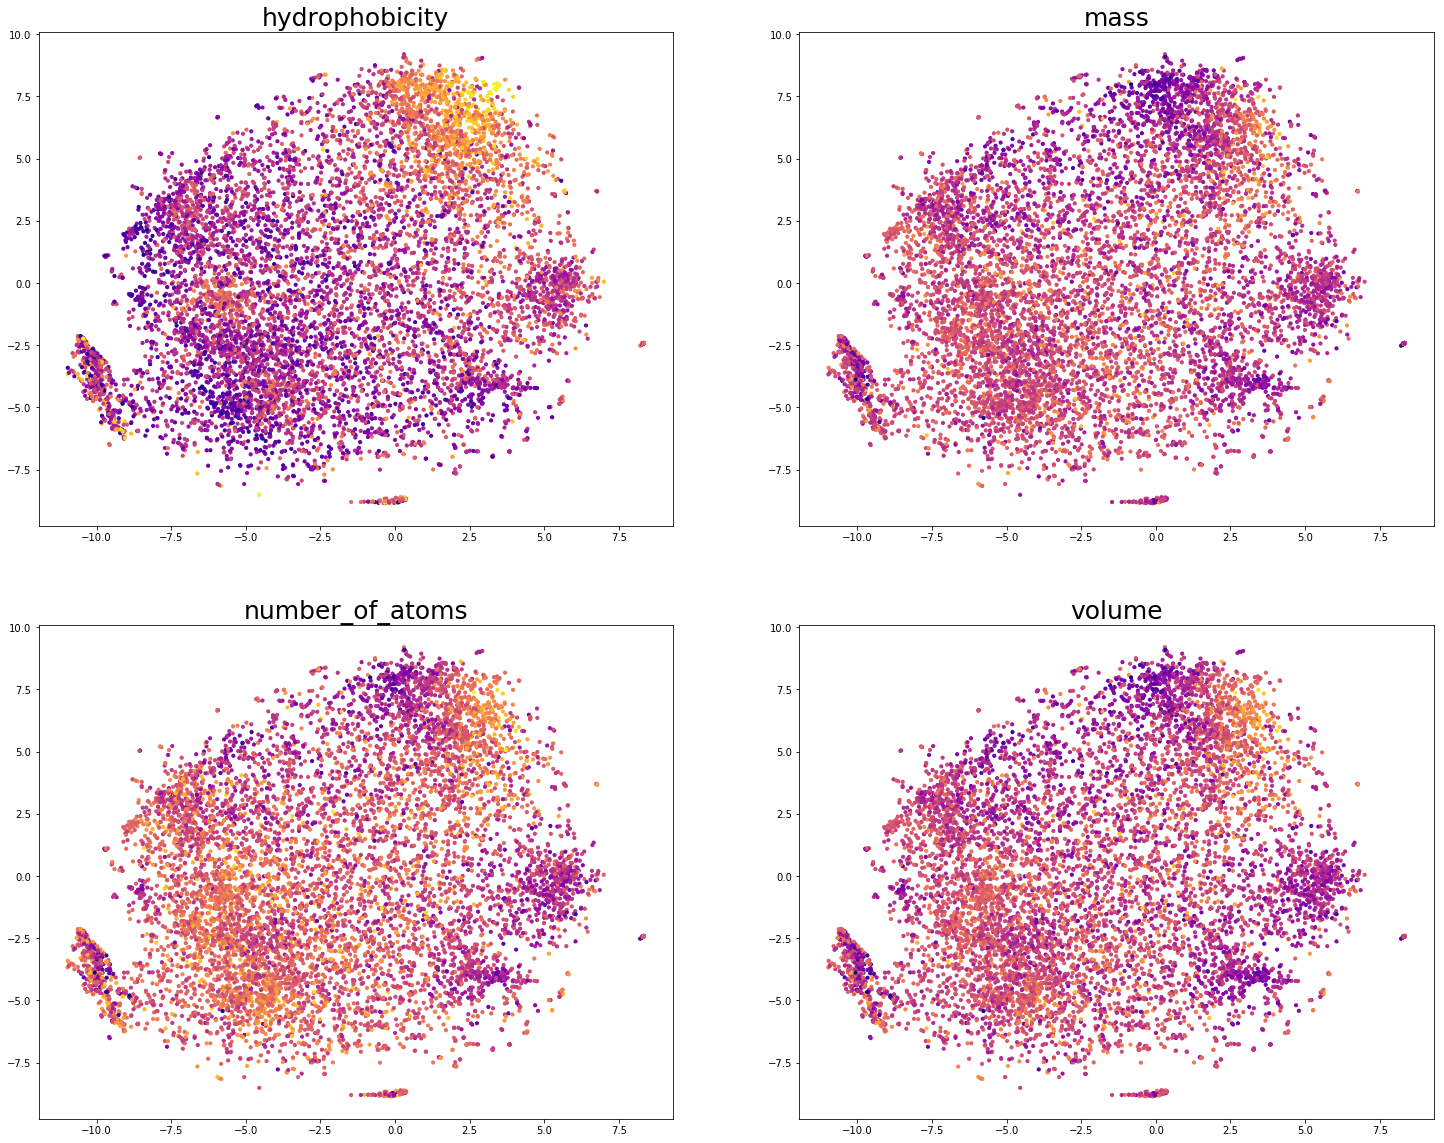

In [39]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [22]:
#Stolen from Gosha
CODON_LEN = 3
SKIP_WINDOW = 12  

def read_process_data(codon_len, skip_window):
    seq_df = pd.read_table('data/family_classification_sequences.tab')
    seq_df.head()
    codon_freq = {}
    for seq in seq_df['Sequences']:
        for i in range(len(seq) - codon_len + 1):
            codon = seq[i : i + 3]
            if codon not in codon_freq:
                codon_freq[codon] = 1
            else:
                codon_freq[codon] += 1

    codons = list(codon_freq.items())
#     codons.sort(key=operator.itemgetter(1), reverse=True)
    print(codons[0], codons[-1])
    
    codon_to_id = {cod: i + 1 for i, (cod, freq) in enumerate(codons)}
    if 'ZZZ' not in codon_to_id:
        codon_to_id['ZZZ'] = 0
    else:
        assert False

    total_size = 0
    for seq in seq_df['Sequences']:
        total_size += len(seq) // 3
        total_size += (len(seq) - 1) // 3
        total_size += (len(seq) - 2) // 3
        total_size += skip_window * 3
    total_size += skip_window

    result = np.zeros(total_size, dtype=np.uint32)

    current_pos = 0
    for seq in seq_df['Sequences']:
        for offset in range(CODON_LEN):
            current_pos += skip_window
            for i in range(offset, len(seq) - codon_len + 1, codon_len):
                result[current_pos] = codon_to_id[seq[i : i + codon_len]]
                current_pos += 1
    current_pos += skip_window
    print(result.shape, current_pos)
    print(result[:200])
    
    return result, codon_to_id
    
stacked_data, codon_to_id = read_or_create('./data/data', lambda: read_process_data(CODON_LEN, SKIP_WINDOW))

reading ./data/data


In [23]:
BATCH_SIZE = 128
TARGETS = 1

def gen_ladder(n):
    return np.array([i for i in range(1, n) for j in range(n - i)])
DELTAS = np.hstack([gen_ladder(SKIP_WINDOW + 1), -gen_ladder(SKIP_WINDOW + 1)])
print(DELTAS)

# DELTAS = np.array([i for i in range(-SKIP_WINDOW, 0)] + [i for i in range(1, SKIP_WINDOW + 1)])


def generate_batches(stacked_data, batch_size):
    while True:
        center_inds = np.random.randint(SKIP_WINDOW, stacked_data.shape[0] - SKIP_WINDOW, batch_size)
#         deltas = np.random.randint(-SKIP_WINDOW, SKIP_WINDOW + 1, batch_size)
#         deltas = np.vstack([np.random.choice(DELTAS, size=(1, TARGETS)) for i in range(BATCH_SIZE)])
        deltas = np.random.choice(DELTAS, size=(BATCH_SIZE, TARGETS))
#         deltas[:, :] = TEMPLATE
#         yield stacked_data[center_inds], stacked_data[center_inds + deltas].reshape(-1, 1)
        yield stacked_data[center_inds], stacked_data[center_inds.reshape(-1, 1) + deltas].reshape(-1, TARGETS)
        
batch_gen = generate_batches(stacked_data, BATCH_SIZE)

[  1   1   1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2
   2   2   2   2   2   3   3   3   3   3   3   3   3   3   3   4   4   4
   4   4   4   4   4   4   5   5   5   5   5   5   5   5   6   6   6   6
   6   6   6   7   7   7   7   7   7   8   8   8   8   8   9   9   9   9
  10  10  10  11  11  12  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1
  -2  -2  -2  -2  -2  -2  -2  -2  -2  -2  -2  -3  -3  -3  -3  -3  -3  -3
  -3  -3  -3  -4  -4  -4  -4  -4  -4  -4  -4  -4  -5  -5  -5  -5  -5  -5
  -5  -5  -6  -6  -6  -6  -6  -6  -6  -7  -7  -7  -7  -7  -7  -8  -8  -8
  -8  -8  -9  -9  -9  -9 -10 -10 -10 -11 -11 -12]


In [24]:
import time

class Timer:
    def __init__(self):
        self.time = time.time()
    
    def get_and_reset(self):
        current_time = time.time()
        delta, self.time = current_time - self.time, current_time
        return delta

In [28]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11949417689151052918, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 45481984
 locality {
   bus_id: 1
 }
 incarnation: 13596155555154994169
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"]

In [33]:
global_embed_matrix = None
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    global final_embed_matrix
    make_dir('checkpoints')
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    timer = Timer()
    
    with tf.Session(graph=g, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in tnrange(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op],
                                              feed_dict=feed_dict)
#             writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.3f}. time = {}'.format(index, total_loss / skip_step, timer.get_and_reset()))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

                final_embed_matrix = sess.run(model.embed_matrix)
                
        final_embed_matrix = sess.run(model.embed_matrix)
        return final_embed_matrix

In [34]:
VOCAB_SIZE = 9425
EMBED_SIZE = 300
OUTER_SIZE = 300
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = 0.001
NUM_TRAIN_STEPS = 1000000
SKIP_STEP = 2000

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()
    
final_embed_matrix = None
train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)


Average loss at step 1999: 26.079. time = 92.76389169692993
Average loss at step 3999: 24.535. time = 93.393728017807
Average loss at step 5999: 22.526. time = 95.23754692077637
Average loss at step 7999: 20.438. time = 93.96043252944946
Average loss at step 9999: 17.948. time = 94.52896666526794
Average loss at step 11999: 16.535. time = 94.71641731262207
Average loss at step 13999: 15.191. time = 93.77762699127197
Average loss at step 15999: 14.218. time = 92.99248743057251
Average loss at step 17999: 13.400. time = 93.92035675048828
Average loss at step 19999: 13.018. time = 94.60426139831543
Average loss at step 21999: 12.334. time = 94.01806998252869
Average loss at step 23999: 12.029. time = 93.6172661781311
Average loss at step 25999: 11.522. time = 94.71217274665833
Average loss at step 27999: 10.841. time = 93.02177429199219
Average loss at step 29999: 10.795. time = 94.29386401176453
Average loss at step 31999: 10.064. time = 94.48882102966309
Average loss at step 33999: 9.8

Average loss at step 271999: 2.804. time = 95.40945148468018
Average loss at step 273999: 2.791. time = 93.23405838012695
Average loss at step 275999: 2.803. time = 92.86318135261536
Average loss at step 277999: 2.800. time = 94.4702455997467
Average loss at step 279999: 2.782. time = 92.65978741645813
Average loss at step 281999: 2.687. time = 94.83516073226929
Average loss at step 283999: 2.748. time = 93.48529815673828
Average loss at step 285999: 2.689. time = 93.72630643844604
Average loss at step 287999: 2.644. time = 93.3559455871582
Average loss at step 289999: 2.782. time = 93.7681074142456
Average loss at step 291999: 2.687. time = 92.5920901298523
Average loss at step 293999: 2.721. time = 95.31733560562134
Average loss at step 295999: 2.613. time = 92.57299184799194
Average loss at step 297999: 2.654. time = 95.11000990867615
Average loss at step 299999: 2.611. time = 92.25730609893799
Average loss at step 301999: 2.587. time = 93.41648244857788
Average loss at step 303999:

Average loss at step 541999: 1.936. time = 68.45682764053345
Average loss at step 543999: 1.967. time = 69.88970470428467
Average loss at step 545999: 1.939. time = 69.32757759094238
Average loss at step 547999: 1.944. time = 69.97709441184998
Average loss at step 549999: 1.941. time = 70.64788126945496
Average loss at step 551999: 1.951. time = 69.96412801742554
Average loss at step 553999: 1.974. time = 69.07887482643127
Average loss at step 555999: 1.958. time = 69.35937714576721
Average loss at step 557999: 1.956. time = 69.42379474639893
Average loss at step 559999: 1.939. time = 68.59832811355591
Average loss at step 561999: 1.983. time = 68.92149114608765
Average loss at step 563999: 1.941. time = 69.10436201095581
Average loss at step 565999: 1.952. time = 69.40024256706238
Average loss at step 567999: 1.997. time = 70.06311440467834
Average loss at step 569999: 1.942. time = 68.5876853466034
Average loss at step 571999: 1.938. time = 68.0090982913971
Average loss at step 57399

Average loss at step 811999: 1.880. time = 68.82329726219177
Average loss at step 813999: 1.880. time = 69.3886730670929
Average loss at step 815999: 1.877. time = 69.351078748703
Average loss at step 817999: 1.881. time = 69.3950891494751
Average loss at step 819999: 1.891. time = 69.4575788974762
Average loss at step 821999: 1.880. time = 69.26107621192932
Average loss at step 823999: 1.867. time = 69.49261212348938
Average loss at step 825999: 1.877. time = 69.37806987762451
Average loss at step 827999: 1.903. time = 69.36039161682129
Average loss at step 829999: 1.863. time = 69.45995998382568
Average loss at step 831999: 1.879. time = 69.40925598144531
Average loss at step 833999: 1.874. time = 69.37752079963684
Average loss at step 835999: 1.861. time = 69.38808560371399
Average loss at step 837999: 1.858. time = 69.44134855270386
Average loss at step 839999: 1.879. time = 69.46713900566101
Average loss at step 841999: 1.881. time = 71.22338128089905
Average loss at step 843999: 

array([[-0.99999857,  0.99999577,  0.99999857, ..., -0.99999321,
         0.99999654,  0.99999827],
       [-0.99999917,  0.99999797,  0.99999893, ..., -0.99999905,
         0.99999738,  0.99999815],
       [-0.99999988,  0.9999997 ,  0.99999988, ..., -0.99999988,
         0.99999958,  0.9999997 ],
       ..., 
       [-0.86766374,  0.8963052 ,  0.89300722, ..., -0.81714392,
         0.90349472,  0.92422789],
       [-0.55094945,  0.66546261,  0.64031219, ..., -0.38781884,
         0.70149601,  0.7610212 ],
       [-0.37664956,  0.54390711,  0.49463308, ..., -0.1956086 ,
         0.58840954,  0.66120839]], dtype=float32)

         x0        x1 codone
0 -4.362445  5.502349    ZZZ
1  4.761728  7.733841    MAF
2  7.464270  4.063278    AFS
3  7.382485  5.514076    FSA
4  4.988397 -1.534126    SAE


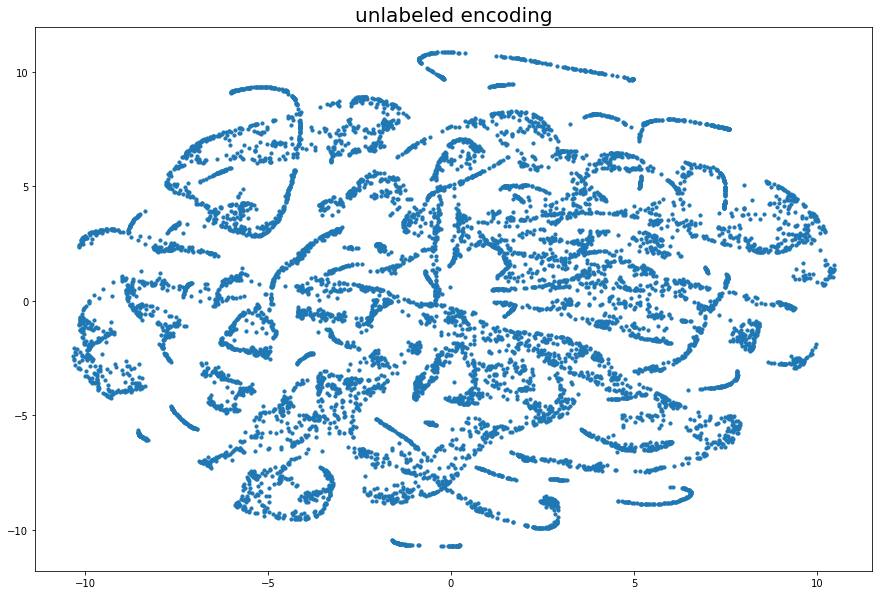

reading data/all_acid_dicts.pickle
  acid  hydrophobicity        mass  number_of_atoms      volume
0  MEV        0.283333  119.813733        19.333333  147.100000
1  NFV       -0.213333  120.135867        19.666667  148.000000
2  FRY       -0.420000  155.510967        24.333333  185.633333
3  VMV       -0.030000  109.819433        19.333333  147.633333
4  HDQ        0.575000  126.785300        18.666667  136.033333
  acid  hydrophobicity        mass  number_of_atoms      volume        x0  \
0  MEV        0.283333  119.813733        19.333333  147.100000  2.236408   
1  NFV       -0.213333  120.135867        19.666667  148.000000  4.148029   
2  FRY       -0.420000  155.510967        24.333333  185.633333  3.574812   
3  VMV       -0.030000  109.819433        19.333333  147.633333  2.351692   
4  HDQ        0.575000  126.785300        18.666667  136.033333  5.487397   

         x1  
0  8.137703  
1  6.196999  
2  3.917590  
3 -2.109659  
4 -7.375097  


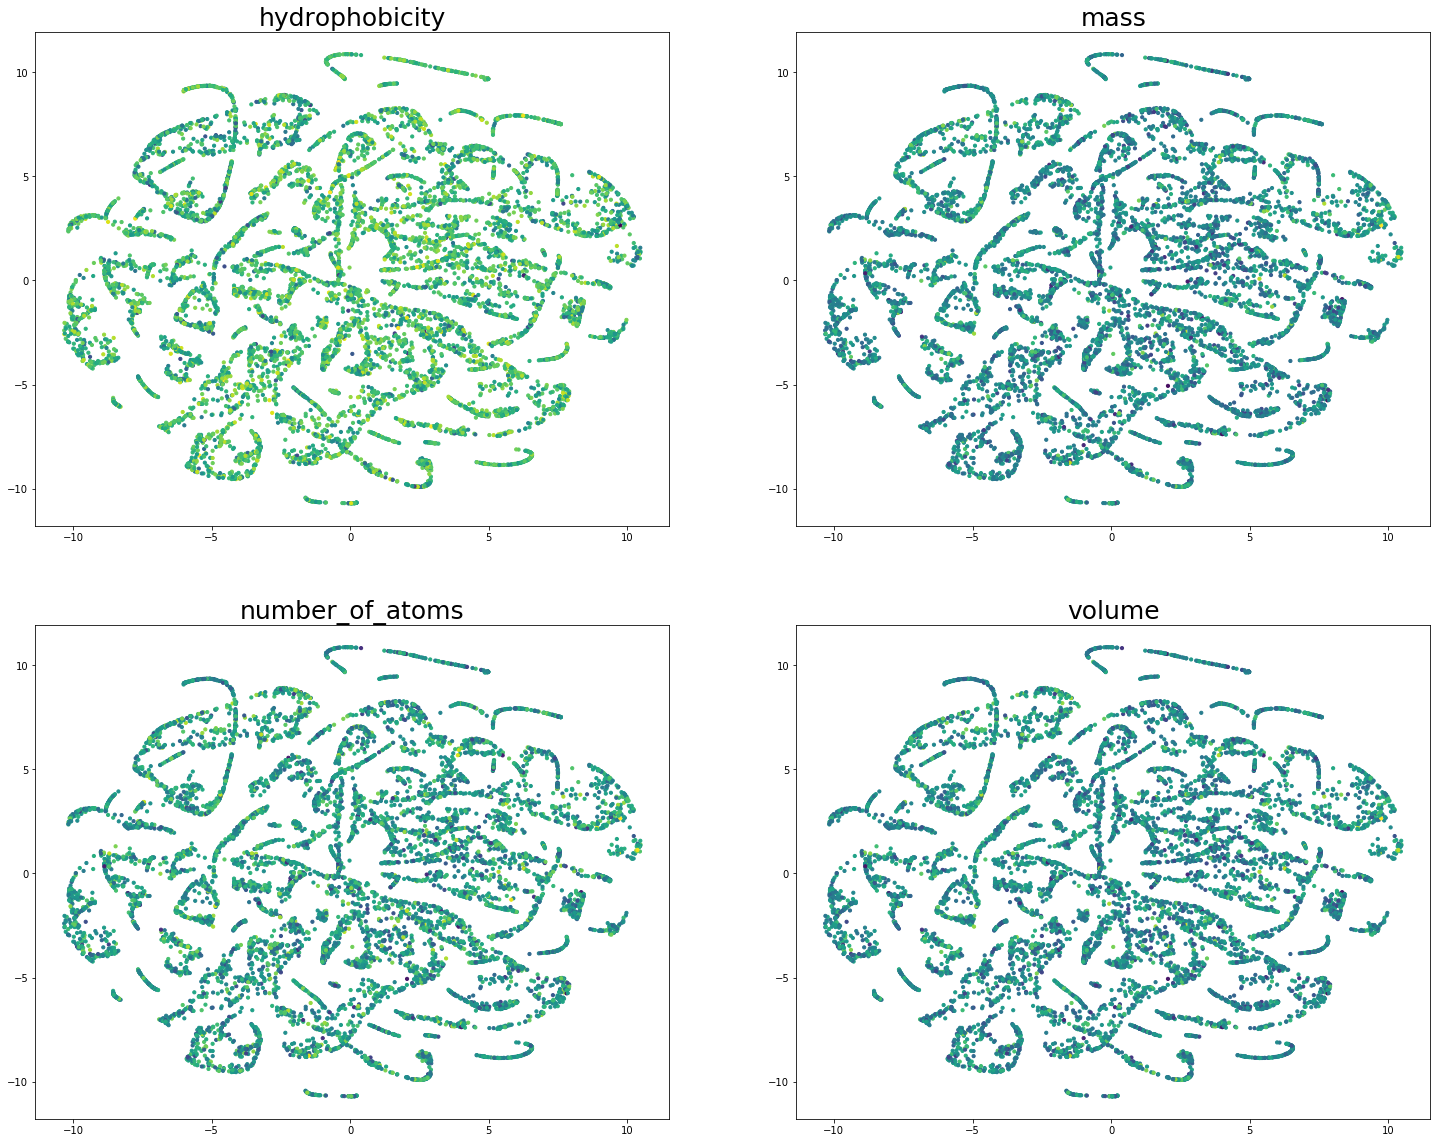

In [41]:
tsne = TSNE(n_components=2, random_state=42)

XX = tsne.fit_transform(final_embed_matrix)

tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(codon_to_id, key=codon_to_id.get)
tsne_df['codone'] = list(unique_codones)
print(tsne_df.head())

def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()
    
plot_tsne_df(tsne_df)

filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

all_acid_df = pd.DataFrame(all_acid_dicts)
print(all_acid_df.head())

final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
print(final_df.head())

def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()
    
plot_embedding_properties(final_df)